In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/GB500/

/content/drive/MyDrive/GB500


In [4]:
import glob
import random
from time import time

import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from utils import get_images, image_preprocess, dice_coef, dice_coef_loss
from unet import unet_completa
#from ActiveContourLoss import Active_Contour_Loss

In [ ]:
SEED = 42
epoch = 100

hd = np.asarray([45 , 25, 40 , 40 , 13, 40, 42 , 33, 6 , 43 , 37 , 8 , 28, 18, 46 , 37, 41 , 41 ]) #, 33, 33 ])
hu = np.asarray([112, 95, 113, 116, 91, 98, 109, 98, 67, 105, 104, 81, 97, 88, 103, 90, 110, 113]) #, 92, 101])

x_train = sorted(glob.glob('data_heart/imagesTr/*'))
y_train = sorted(glob.glob('data_heart/labelsTr/*'))
img_xtrain = get_images(x_train,hd,hu)
img_ytrain = get_images(y_train,hd,hu)

#predict_vol = []
dice_metric = []
tempo = []
local = 'outputs_unet/'


In [ ]:
import matplotlib.pyplot as plt
def quick_plot(value):
  value_shape = value[0].shape
  plot_value = value[0].reshape(value_shape[0], value_shape[1])
  plt.imshow(plot_value)
  plt.grid(linewidth=.5)
  plt.ylim(0,6)
  plt.xlim(0,6)
  plt.title(f"Min: {np.min(plot_value)} Max: {np.max(plot_value)}")
  plt.show()


In [ ]:
from keras import backend as K
import numpy as np

def Active_Contour_Loss(y_true, y_pred, debug = False):
  """
  lenth term
  """

  #          ch, n, x, y
  #          n , x, y, ch
  x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:] # horizontal and vertical directions 
  y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:]


  delta_x = x[:,1:,:-2,:]**2
  delta_y = y[:,:-2,1:,:]**2

  if debug:
    print("Y Pred")
    quick_plot(y_pred)
    print("Horizontal")
    quick_plot(x)
    print("Vertical")
    quick_plot(y)
    print("Delta X")
    quick_plot(delta_x)
    print("Delta Y")
    quick_plot(delta_y)

  delta_u = K.abs(delta_x + delta_y)

  epslon = 0.00000001
  w = 1
  lenth = w * K.mean(K.sqrt(delta_u + epslon)) # equ.(11) in the paper
  
  """
  region term
  """

  C_1 = tf.ones((256, 256))
  C_2 = tf.zeros((256, 256))
  
  region_in =   K.abs( K.mean( y_pred[:,:,:,0] * ((C_1 - y_true[:,:,:,0])**2) ) )      # equ.(12) in the paper
  region_out =  K.abs( K.mean( (1-y_pred[:,:,:,0]) * ((C_2 - y_true[:,:,:,0])**2) ) )  # equ.(12) in the paper

  lambdaP = 1 # lambda parameter could be various.
  mu = 1 # mu parameter could be various.

  eq = lenth + lambdaP * (mu * region_in + region_out)

  return eq

In [ ]:
size_img = 256
train_X, valid_X, train_ground, valid_ground = train_test_split(img_xtrain, img_ytrain, test_size=0.2, random_state = SEED)
train_X, valid_X, train_ground, valid_ground = image_preprocess(train_X, valid_X, train_ground, valid_ground, size_img = size_img)

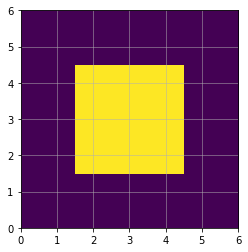

In [ ]:
img_test = np.zeros((1, 7, 7, 1))
img_test[:,2:5, 2:5,:] = 1
plt.imshow(img_test[0].reshape((7, 7)))
plt.ylim(0,6)
plt.xlim(0,6)
plt.grid(linewidth=.5)
plt.show()

Y Pred


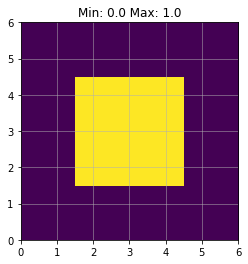

Horizontal


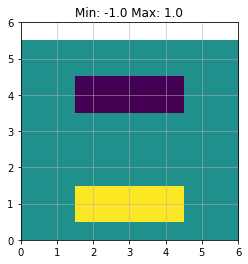

Vertical


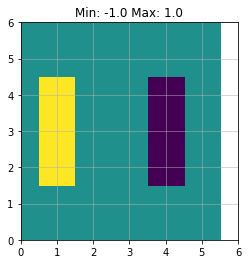

Delta X


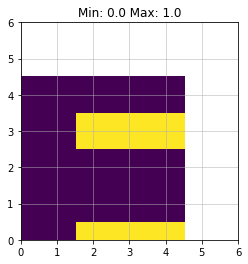

Delta Y


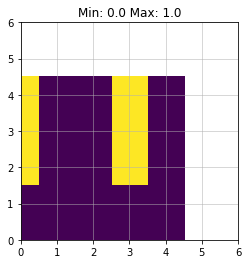

InvalidArgumentError: ignored

In [ ]:
i = 0
Active_Contour_Loss(img_test, img_test, True)

In [ ]:
for i in range(10):
    random.seed(time())
    seed_min = 0
    seed_max = 2**20
    SEED = random.randint(seed_min, seed_max)
    print("Rodando Pela %i vez"%(i+1))
    train_X, valid_X, train_ground, valid_ground = train_test_split(img_xtrain, img_ytrain, test_size=0.2, random_state = SEED)
    
    size_img = 256
    
    train_X, valid_X, train_ground, valid_ground = image_preprocess(train_X, valid_X, train_ground, valid_ground, size_img = size_img)
    
    inicial = time()
    model = unet_completa(size_img)
    #model.compile(optimizer = Adam(learning_rate = 1e-5), loss = dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer = Adam(learning_rate = 1e-5), loss = Active_Contour_Loss, metrics=[dice_coef])

    reduce_lr = ReduceLROnPlateau(monitor = 'loss', patience = 2, verbose = 1)
    es = EarlyStopping(monitor = 'loss', patience = 5, verbose = 1)

    history = model.fit(x = train_X, y = train_ground, batch_size = 8, epochs = epoch, callbacks = [reduce_lr, es])
    final = time()
    
    model.save(local + 'Heart_Model_%i.h5'%(i))
    
    predicao = model.predict(valid_X)
    predicao = predicao > 0.5
    predicao = np.float64(predicao)

    dice_metric.append(dice_coef(predicao, valid_ground).numpy())
    print(dice_metric[i])
    

    tempo_total = final - inicial
    tempo.append(tempo_total)
    print("rodou em : %f"%(tempo_total))
    K.clear_session()

np.savetxt(local + 'Dice Metric.txt', dice_metric)
np.savetxt(local + 'Tempo.txt', tempo)